# Dataset Info:
# COVID-19 RADIOGRAPHY
A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images.

<br>
<hr>
<br>

### Citation:
- M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676. [Paper link](https://ieeexplore.ieee.org/document/9144185)

- Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. [Paper Link](https://doi.org/10.1016/j.compbiomed.2021.104319)

<br>
<hr>
<br>

### Acknowledgments:
Thanks to the Italian Society of Medical and Interventional Radiology (SIRM) for publicly providing the COVID-19 Chest X-Ray dataset, Valencia Region Image Bank (BIMCV) padchest dataset and would like to thank J. P. Cohen for taking the initiative to gather images from articles and online resources. Finally to the Chest X-Ray Images (pneumonia) database in Kaggle and Radiological Society of North America (RSNA) Kaggle database for making a wonderful X-ray database for normal, lung opacity, viral, and bacterial pneumonia images. Also, a big thanks to our collaborators!

<br>
<hr>
<br>

### Dataset Link:
[COVID-19 Radiography Database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

# Motivation:
Thousands of individuals have died as a result of the coronavirus epidemic, which has afflicted millions of people around the world. Any technical device that allows for rapid and accurate COVID-19 infection detection can be extremely beneficial to healthcare providers.

X-ray imaging is an easily accessible method used to diagnose COVID-19 patients, according to Chowdhury et al. (2020). Despite the fact that regular Chest X-Ray (XCR) scans can help with early detection of suspected cases, the images of various viral pneumonia patients are identical. As a result, radiologists have a hard time distinguishing COVID-19 from other viral pneumonia patients.

The goal of this database and current study is to see how useful artificial intelligence (AI) can be in detecting COVID-19 from chest X-ray pictures quickly and accurately.

# Contents:
<blockquote>
1. Reading the Dataset & Selecting 2 classes <br>
2. EDA <br>
3. Data Augmentation <br>
4. Train-Test Split <br>
5. Model Training <br>
6. Fine Tuning the Model <br>
7. Plotting Losses
</blockquote>

# 1. Reading the Dataset

There are a total of 21165 samples, which are classified into four categories:
1. Covid-19
2. Lung Opacity
3. Normal
4. Viral Pneumonia

The photos are all in the Portable Network Graphics (PNG) file type and are 299x299 pixels in size. The database presently contains 3,616 COVID-19 positive cases, 10,192 Normal, 6,012 Lung Opacity (Non-COVID lung infection), and 1,345 Viral Pneumonia pictures, according to the most recent update.

We will only train our model on two of these four classes, namely the 'Normal' and 'COVID' classes.

In [1]:
# Import the required modules
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [2]:
# Set dataset path

DATASET_PATH = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# There are two classes of images that we will deal with
cls = ['COVID', 'Normal']

# 2. Exploratory Data Analysis

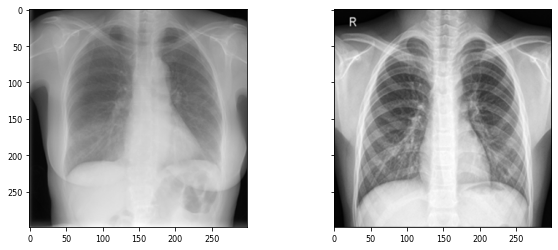

In [3]:
covid_path = os.path.join(DATASET_PATH, cls[0], '*')
covid = glob.glob(covid_path)
covid = io.imread(covid[0])

normal_path = os.path.join(DATASET_PATH, cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)

axes[0].imshow(covid, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [4]:
print(f'Image shape for COVID dataset is: {covid.shape}')
print(f'Image shape for Normal dataset is: {normal.shape}')

Image shape for COVID dataset is: (299, 299)
Image shape for Normal dataset is: (299, 299)


In [5]:
print(f'Number of COVID Images: {len(os.listdir(covid_path[:-2]))} \
\nNumber of Non-COVID Images: {len(os.listdir(normal_path[:-2]))}')

Number of COVID Images: 3616 
Number of Non-COVID Images: 10192


> <strong> This is an Imbalanced Dataset!! </strong>
>
> To deal with this issue, we have applied ***focal loss*** later in the section.

## Preprocessing Images

In [6]:
# Histogram Equalization

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

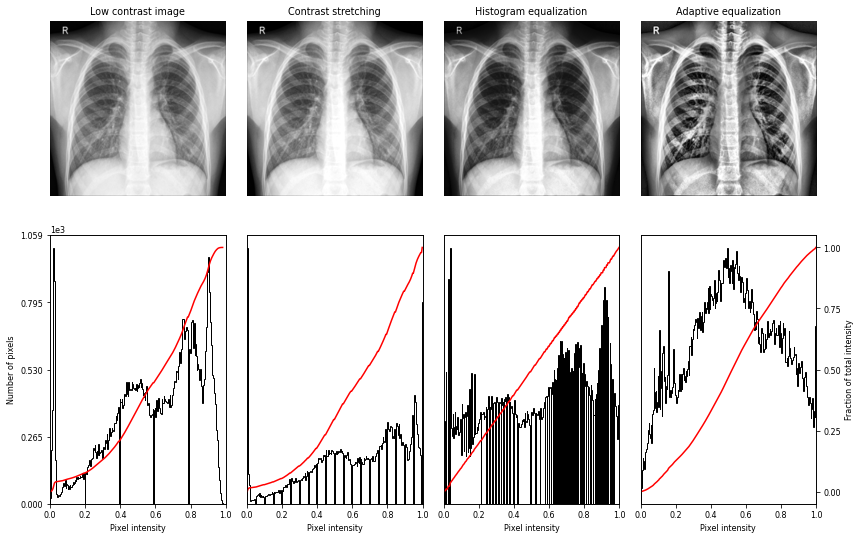

In [7]:
# Load a normal image
img = normal

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

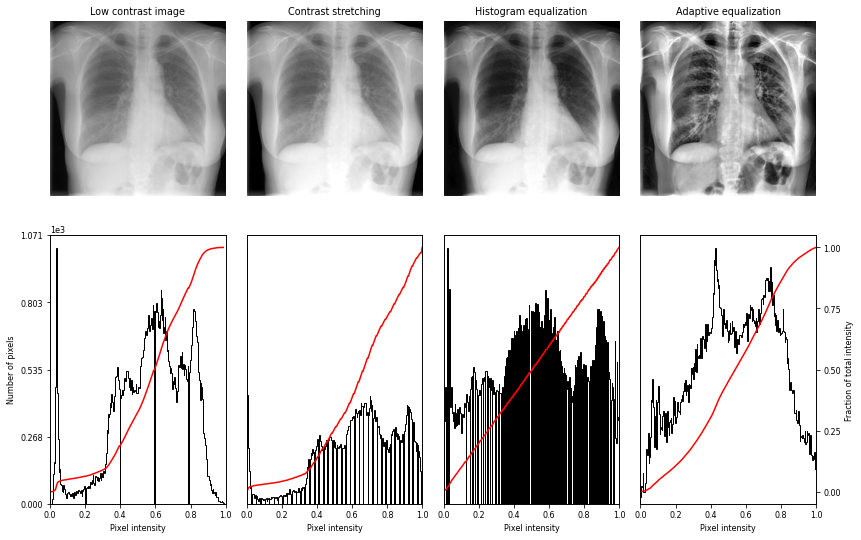

In [8]:
# Load a covid image
img = covid

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

# 3. Data Augmentation

In [9]:
# Create the list of paths to the images

# Lists for access paths
listCovidPaths = []
listNormalPaths = []

# Get covid images files paths
for root, directories, files in os.walk(covid_path[:-2]):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))
        
# Get normal images files paths
for root, directories, files in os.walk(normal_path[:-2]):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

# Shuffle lists for random train / test

random.shuffle(listCovidPaths)
random.shuffle(listNormalPaths)

# 4. Train-Test Split

In [10]:
# Create new folders for image training

# main folder
!mkdir ./Data/

# Train data folders
!mkdir ./Data/Train/
!mkdir ./Data/Train/Covid/
!mkdir ./Data/Train/Normal/

# Test data folders
!mkdir ./Data/Test/
!mkdir ./Data/Test/Covid/
!mkdir ./Data/Test/Normal/

# Paths to covid images folders
pathCovidTrain = './Data/Train/Covid/'
pathCovidTest = './Data/Test/Covid/'

# Paths to normal images folders
pathNormalTrain = './Data/Train/Normal/'
pathNormalTest = './Data/Test/Normal/'

In [11]:
# Move files to new folders in the 80:20 ratio

len_covid = len(os.listdir(covid_path[:-2]))
len_normal = len(os.listdir(normal_path[:-2]))
covid_80 = round(len(os.listdir(covid_path[:-2])) * 0.8)     # 80% of the COVID data
normal_80 = round(len(os.listdir(normal_path[:-2])) * 0.8)   # 80% of the Normal data

# Move covid images files to new folders
for i in range(len_covid):
    if i < covid_80:
        copy_file(listCovidPaths[i], pathCovidTrain)
    else : 
        copy_file(listCovidPaths[i], pathCovidTest)

# Move normal images files to new folders
for i in range(len_normal):
    if i < normal_80:
        copy_file(listNormalPaths[i], pathNormalTrain)
    else:
        copy_file(listNormalPaths[i], pathNormalTest)

In [12]:
# Definition of data generators

# for train data
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center = True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    fill_mode = 'nearest'
)

# for test data
testGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,    
)

In [13]:
# Build data generators

# Build for train data
pathTrainDir = './Data/Train/'

trainGeneratorBuild = trainGenerator.flow_from_directory(
    pathTrainDir,
    target_size = (299, 299),
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True 
)

# Build for test data
pathTestDir = './Data/Test/'

testGeneratorBuild = testGenerator.flow_from_directory(
    pathTestDir,
    target_size = (299, 299),
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True
)

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


# 5. Model Traning

## Train Model from Scratch

In [14]:
# COVID and Normal dataset directory
BASIS_DIR = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'
CLASSES = ["COVID",  "Normal"]

In [15]:
#Image augmentation process:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest',
    
    #split dataset to training(80%) and validation(20%):
    validation_split = 0.2
)

In [16]:
# Training dataset and Validation dataset:
train_data = train_datagen.flow_from_directory(
    directory=BASIS_DIR,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    subset='training',
    classes=CLASSES
    )
val_data = train_datagen.flow_from_directory(
    directory=BASIS_DIR,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    subset='validation',
    classes=CLASSES
    )

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [17]:
#Using sequential model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

In [18]:
# Define our custom loss function

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


# Compile our model
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

In [19]:
# Training process:
start = datetime.datetime.now()

number_epochs = 25

history = model.fit(train_data,
                    epochs = number_epochs, 
                    validation_data = val_data,
                    verbose = 1)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

# verbose = 0 => silent,
#         = 1 => progress bar,
#         = 2 => one line per epoch

Epoch 1/25
346/346 [==============================] - 300s 848ms/step - loss: 2.0569 - accuracy: 0.5402 - val_loss: 1.7863 - val_accuracy: 0.7657
Epoch 2/25
346/346 [==============================] - 295s 853ms/step - loss: 1.8357 - accuracy: 0.6450 - val_loss: 1.8213 - val_accuracy: 0.8048
Epoch 3/25
346/346 [==============================] - 301s 872ms/step - loss: 1.7542 - accuracy: 0.6658 - val_loss: 1.4909 - val_accuracy: 0.7534
Epoch 4/25
346/346 [==============================] - 308s 891ms/step - loss: 1.5833 - accuracy: 0.7036 - val_loss: 1.4505 - val_accuracy: 0.7849
Epoch 5/25
346/346 [==============================] - 302s 874ms/step - loss: 1.5420 - accuracy: 0.7194 - val_loss: 1.3528 - val_accuracy: 0.7693
Epoch 6/25
346/346 [==============================] - 293s 846ms/step - loss: 1.4379 - accuracy: 0.7471 - val_loss: 1.3171 - val_accuracy: 0.7595
Epoch 7/25
346/346 [==============================] - 291s 841ms/step - loss: 1.4074 - accuracy: 0.7534 - val_loss: 1.3220 -

In [20]:
model.save('my_model_1.h5')

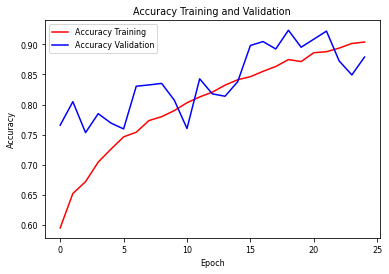

In [21]:
# Plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

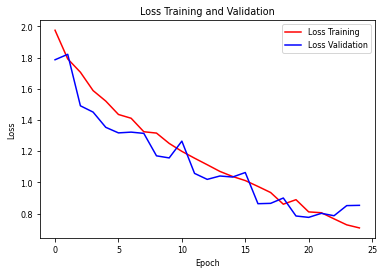

In [22]:
# Plotting training loss and validation loss
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

## Train Model using Trasfer Learning

In [23]:
# Define the Keras model
# Use InceptionResNetV2 Keras model

engine = tf.keras.applications.InceptionResNetV2(
    # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
    include_top = False,

    # Use Imagenet weights
    weights = 'imagenet',

    # Define input shape to 224x224x3
    input_shape = (224, 224, 3),

    # Set classifier activation to sigmoid
    classifier_activation = 'sigmoid'
)

219062272/219055592 [==============================] - 1s 0us/step


In [24]:
# Define the Keras model outputs

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'dense_output')(x)


# Build the Keras model

model = tf.keras.models.Model(inputs = engine.input, outputs = out)


### (i) Loss: binary_crossentropy

In [25]:
# Compile the model

model.compile(
    # Set optimizer to Adam(0.001)
    optimizer = tf.keras.optimizers.Adam(0.001),

    # Set loss to binary crossentropy
    loss = 'binary_crossentropy',

    # Set metrics to accuracy
    metrics = ['accuracy']
)

In [26]:
# Fit Keras model
start = datetime.datetime.now()

history = model.fit_generator(
    # Use train generator
    trainGeneratorBuild,

    # Set epochs to 12
    epochs = 12,

    # Set steps per epochs to 300
    steps_per_epoch = 300,
    
    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/12
300/300 [==============================] - 151s 444ms/step - loss: 0.2860 - accuracy: 0.8850
Epoch 2/12
300/300 [==============================] - 135s 450ms/step - loss: 0.1455 - accuracy: 0.9495
Epoch 3/12
300/300 [==============================] - 133s 443ms/step - loss: 0.1301 - accuracy: 0.9524
Epoch 4/12
300/300 [==============================] - 134s 446ms/step - loss: 0.1128 - accuracy: 0.9624
Epoch 5/12
300/300 [==============================] - 133s 443ms/step - loss: 0.1102 - accuracy: 0.9629
Epoch 6/12
300/300 [==============================] - 132s 441ms/step - loss: 0.0997 - accuracy: 0.9662
Epoch 7/12
300/300 [==============================] - 134s 446ms/step - loss: 0.1059 - accuracy: 0.9602
Epoch 8/12
300/300 [==============================] - 132s 441ms/step - loss: 0.0904 - accuracy: 0.9646
Epoch 9/12
300/300 [==============================] - 133s 441ms/step - loss: 0.0808 - accuracy: 0.9700
Epoch 10/12
300/300 [==============================] - 132s 440m

In [27]:
model.save('my_model_2.h5')

In [28]:
# Create a graph representing the loss

# Get loss data
lossG = history.history['loss']
accuracyG = history.history['accuracy']
epochs = [i for i in range(len(lossG))]

# Create graph
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = lossG,
        name = 'Loss',
        marker = dict(
            color = 'rgba(250,50,50,1)'        
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = accuracyG,
        name = 'Accuracy',
        marker = dict(
            color = 'rgba(50,250,50,1)'        
        )
    )
)

fig.update_layout(
    title = 'Model loss',
    template = 'plotly_white'
)

fig.update_xaxes(
    title_text='Epochs'
)
fig.update_yaxes(
    title_text='Loss / Accuracy values'
)

fig.show()

In [29]:
# Checke the accuracy of the Keras model on the test data

testLoss, testAccuracy = model.evaluate(
    # Use test generator
    testGeneratorBuild,
    
    # Set verbose to 1
    verbose = 1
)

# Print results
print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

173/173 [==============================] - 22s 108ms/step - loss: 0.2389 - accuracy: 0.9236
Accuracy of model : 92.36 %
Loss of model : 0.2389


# 6. Fine Tuning the Model

### (ii) Loss: Focal Loss
Because our dataset is unbalanced, we can utilise this strategy to balance the weighting of our training instances.
Instead of giving all training examples the same weight, focus loss gives the well-classified instances a lower weight. As a result, more training emphasis is placed on data that is difficult to classify!

If we have a data imbalance in practise, our majority class will soon become well-classified because we have considerably more data for it. As a result, we may use the focus loss to give those minority class instances more relative weight during training, ensuring that we obtain high accuracy on our minority class as well.

In [30]:
# Define our custom loss function

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [31]:
# Compile our model

adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

In [32]:
# Fit Keras model
start = datetime.datetime.now()

history = model.fit_generator(
    # Use train generator
    trainGeneratorBuild,

    # Set epochs to 20
    epochs = 20,

    # Set steps per epochs to 300
    steps_per_epoch = 300,       # batch_size

    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/20
300/300 [==============================] - 148s 439ms/step - loss: 0.1306 - accuracy: 0.9820
Epoch 2/20
300/300 [==============================] - 133s 442ms/step - loss: 0.1475 - accuracy: 0.9797
Epoch 3/20
300/300 [==============================] - 132s 438ms/step - loss: 0.0896 - accuracy: 0.9818
Epoch 4/20
300/300 [==============================] - 133s 442ms/step - loss: 0.0734 - accuracy: 0.9843
Epoch 5/20
300/300 [==============================] - 132s 439ms/step - loss: 0.0637 - accuracy: 0.9908
Epoch 6/20
300/300 [==============================] - 132s 438ms/step - loss: 0.0437 - accuracy: 0.9894
Epoch 7/20
300/300 [==============================] - 133s 442ms/step - loss: 0.0437 - accuracy: 0.9875
Epoch 8/20
300/300 [==============================] - 132s 438ms/step - loss: 0.0432 - accuracy: 0.9901
Epoch 9/20
300/300 [==============================] - 133s 442ms/step - loss: 0.0576 - accuracy: 0.9883
Epoch 10/20
300/300 [==============================] - 132s 438m

In [33]:
model.save('my_model_3.h5')

# 7. Plot Loss

In [34]:
# Create a graph representing the loss

# Get loss data
lossG = history.history['loss']
accuracyG = history.history['accuracy']
epochs = [i for i in range(len(lossG))]

# Create graph
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = lossG,
        name = 'Loss',
        marker = dict(
            color = 'rgba(250,50,50,1)'        
        )
    )
)

fig.add_trace(
    go.Scatter(
        x = epochs,
        y = accuracyG,
        name = 'Accuracy',
        marker = dict(
            color = 'rgba(50,250,50,1)'        
        )
    )
)

fig.update_layout(
    title = 'Model loss',
    template = 'plotly_white'
)

fig.update_xaxes(
    title_text='Epochs'
)
fig.update_yaxes(
    title_text='Loss / Accuracy values'
)

fig.show()

In [35]:
# Check the accuracy of the Keras model on the test data

testLoss, testAccuracy = model.evaluate(
    # Use test generator
    testGeneratorBuild,
    
    # Set verbose to 1
    verbose = 1
)

# Print results
print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

173/173 [==============================] - 21s 106ms/step - loss: 0.0463 - accuracy: 0.9877
Accuracy of model : 98.77 %
Loss of model : 0.0463
